In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml

with open("configuration.yaml", "r") as yml_file:
    config = yaml.load(yml_file, yaml.Loader)

In [2]:
data = pd.read_csv('data/final_dataset.csv')

data['TF_binding_site_agg'] = np.logical_or(data['TF_binding_site'], data['TF_binding_site_variant']).astype(int)

data['TF_loss_add'] = data['TF_binding_site_agg'] + data['TF_loss']
data['TF_gain_add'] = data['TF_binding_site_agg'] + data['TF_gain']
data['TF_loss_diff_add'] = data['TF_binding_site_agg'] + data['TF_loss_diff']
data['TF_gain_diff_add'] = data['TF_binding_site_agg'] + data['TF_gain_diff']

data['SpliceAI_pred_DP_AG'] = abs(data['SpliceAI_pred_DP_AG'])
data['SpliceAI_pred_DP_AL'] = abs(data['SpliceAI_pred_DP_AL'])
data['SpliceAI_pred_DP_DG'] = abs(data['SpliceAI_pred_DP_DG'])
data['SpliceAI_pred_DP_DL'] = abs(data['SpliceAI_pred_DP_DL'])

In [3]:
COLUMNS_TRAINING = config['COLUMNS_TRAINING']

BIASED_COLUMNS = ['chr', 'ref_x', 'IG_C_gene', 'IG_D_gene', 'IG_J_gene', 'IG_J_pseudogene']

COLUMNS_TRAINING = [x for x in COLUMNS_TRAINING if x not in BIASED_COLUMNS]
for col in list(set(COLUMNS_TRAINING) - set(data.columns)):
    data[col] = 0

numeric_cols = data[COLUMNS_TRAINING].select_dtypes(include=['float64', 'int64', 'int32']).nunique()

COLUMNS_TO_SHOW = numeric_cols[numeric_cols > 2].index  # pick numeric columns that are not one-hot encoded
    
COLUMN_LABELS = [item[:14] + '\n' + item[14:] for item in COLUMNS_TO_SHOW]

# Boxplot

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(30, 30))

bplot1 = ax1.boxplot(data[COLUMNS_TO_SHOW].iloc[:, 0:11],
                     vert=True,
                     patch_artist=True,
                     boxprops = dict(facecolor = "lightblue"),
                     capprops = dict(color = "red", linewidth = 4),
                     labels=COLUMN_LABELS[0:11])

bplot2 = ax2.boxplot(data[COLUMNS_TO_SHOW].iloc[:, 11:22],
                     vert=True,
                     patch_artist=True,
                     boxprops = dict(facecolor = "lightblue"),
                     capprops = dict(color = "red", linewidth = 4),
                     labels=COLUMN_LABELS[11:22])

# adding horizontal grid lines
for ax in [ax1, ax2]:
    ax.yaxis.grid(True)
    ax.set_xlabel('Features', fontsize=20)
    ax.set_ylabel('Normalized Observed values', fontsize=20)
    ax.tick_params(axis='y', labelsize=20)
    ax.tick_params(axis='x', labelsize=20)

fig.suptitle('Boxplot Normalised Dataset', fontsize=30)
fig.tight_layout(pad=2)
plt.show()

# Histogram

In [ ]:
COLUMNS_TRAINING_LABELS = [item[:14] + '\n' + item[14:] for item in COLUMNS_TRAINING]
num = 8
col = 0
fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(30, 30))
for i in range(0, num):
    for j in range(0, num):
        colour_dict = {0: 'pink', 1: 'lightblue'}
        axes[i][j].hist([data.loc[data['driver'] == x, COLUMNS_TRAINING[col]] for x in colour_dict.keys()],
                color=[colour_dict[x] for x in colour_dict.keys()],
                edgecolor='black',
                stacked=True)
        axes[i][j].set_xlabel(COLUMNS_TRAINING_LABELS[col], fontsize=20, wrap=True)
        axes[i][j].tick_params(axis='y', labelsize=15)
        axes[i][j].tick_params(axis='x', labelsize=15)

        col = col + 1
        if col >= len(COLUMNS_TRAINING):
            break

fig.suptitle('Histogram of Normalised Dataset', fontsize=30)
fig.legend(colour_dict, labels=['non-driver', 'driver'], loc='upper left', ncol = 2, fontsize=20)
fig.tight_layout(pad=2)

# Correlation Matrix

In [ ]:
COLUMNS_TRAINING = ['ada_score', 'rf_score',
                    'ENSP', 'UNIPARC', 'GO', 'SpliceAI_pred_DP_AG', 'SpliceAI_pred_DP_AL',
                    'SpliceAI_pred_DP_DG', 'SpliceAI_pred_DP_DL', 'SpliceAI_pred_DS_AG',
                    'SpliceAI_pred_DS_AL', 'SpliceAI_pred_DS_DG', 'SpliceAI_pred_DS_DL',
                    '3_prime_UTR_variant', '5_prime_UTR_variant',
                    'NMD_transcript_variant', 
                    'downstream_gene_variant',
                    'intergenic_variant', 'intron_variant',
                    'non_coding_transcript_exon_variant', 'non_coding_transcript_variant',
                    'regulatory_region_variant',
                    'splice_donor_variant', 'splice_polypyrimidine_tract_variant',
                    'upstream_gene_variant', 'MODIFIER', 'MotifFeature',
                    'RegulatoryFeature', 'Transcript', 'CTCF_binding_site',
                    'enhancer', 'nonsense_mediated_decay',
                    'processed_pseudogene', 'processed_transcript', 'promoter',
                    'protein_coding', 'retained_intron',
                    'unprocessed_pseudogene',
                    'CTCF_interactions', 'POLR2A_interactions', 'CTCF_loops', 'POLR2A_loops',
                    'DNA', 'LINE', 'LTR', 'SINE', 'Simple_repeat',
                    'known_driver_gene', 'known_driver_gene_100kb_downstream', 'known_driver_gene_100kb_upstream', 'known_driver_gene_10kb_downstream',
                    'known_driver_gene_10kb_upstream', 'known_driver_gene_2kb_downstream', 'known_driver_gene_2kb_upstream',
                    'splice_acceptor_variant', 'splice_donor_region_variant', 'splice_donor_5th_base_variant',
                    'missense_variant', 'synonymous_variant', 'stop_gained', 'stop_lost', 'splice_region_variant', 'inframe_insertion', 'frameshift_variant',
                    'TF_loss', 'TF_gain', 'TF_loss_diff', 'TF_gain_diff',
                    'known_lncrna', 'known_lncrna_100kb_downstream', 'known_lncrna_100kb_upstream', 'known_lncrna_10kb_downstream',
                    'known_lncrna_10kb_upstream', 'known_lncrna_2kb_downstream', 'known_lncrna_2kb_upstream'
                  ]

TO_REMOVE = []

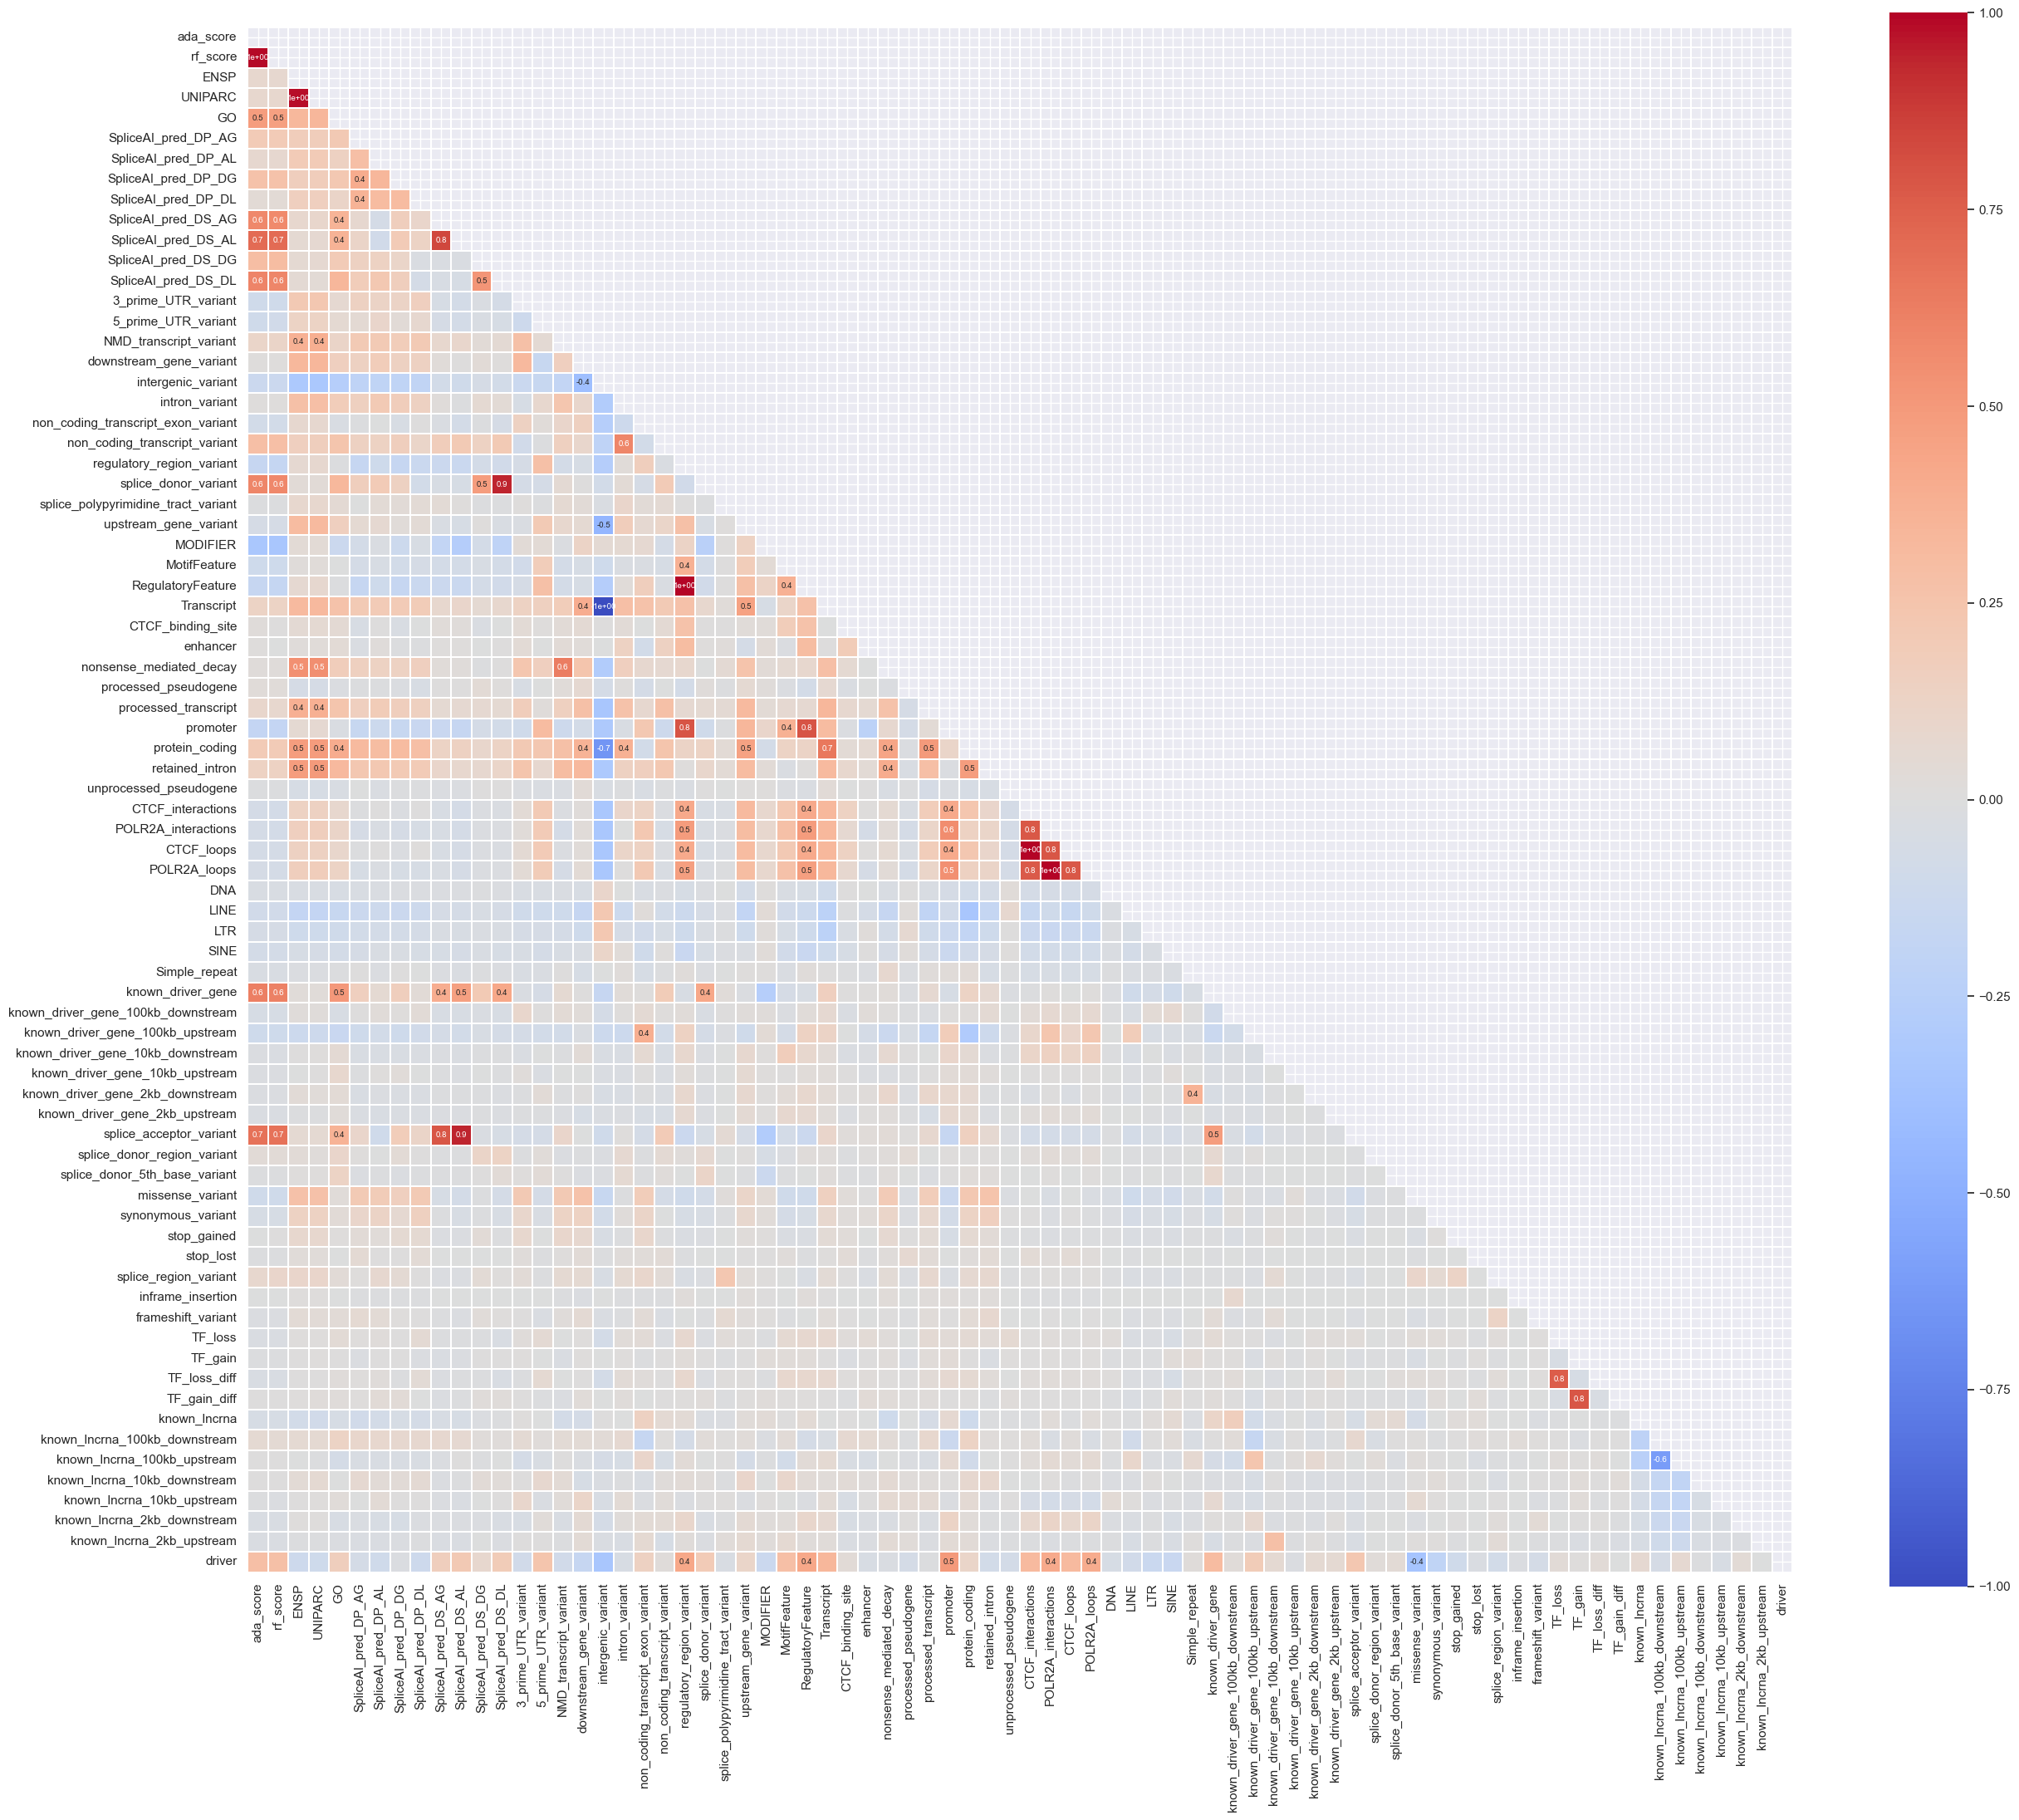

In [4]:
COLUMNS_WITH_DRIVER = COLUMNS_TRAINING
COLUMNS_WITH_DRIVER.append('driver')
corr_matrix = data[COLUMNS_TRAINING].corr()
matrix = np.triu(corr_matrix)
sns.set(font_scale=0.6)
# sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(rc={'figure.figsize':(30,30)})
# sns.set(rc=)

ax= sns.heatmap(corr_matrix, mask=matrix, vmin=-1, vmax=+1, center=0,
            square=True, linewidths=.1, cbar_kws={"shrink": .82},annot=True,
            fmt='.1',annot_kws={"size":7}, cmap='coolwarm')

sns.set()
for t in ax.texts:
    if float(t.get_text())>=0.4 or float(t.get_text())<=-0.4:
        t.set_text(t.get_text()) #if the value is greater than 0.4 then I set the text 
    else:
        t.set_text("") # if not it sets an empty text